In [1]:
from msmbuilder.dataset import dataset
xyz = dataset('/media/scottzhuang/data/MD/msm' + "/*.xtc",
              topology='/media/scottzhuang/data/MD/msm/4NPQ_pH70_md5.pdb',
              stride=1)
print("{} trajectories".format(len(xyz)))
# msmbuilder does not keep track of units! You must keep track of your
# data's timestep
to_ns = 10
print("with length {} ns".format(set(len(x)*to_ns for x in xyz)))

56 trajectories
with length {770, 1030, 1040, 790, 920, 1050, 540, 800, 930, 1060, 550, 680, 810, 1070, 820, 1590, 950, 830, 1470, 960, 1090, 1100, 590, 720, 980, 600, 990, 1120, 870, 1000, 620, 750, 880, 1010, 890} ns


In [4]:
from msmbuilder.featurizer import DihedralFeaturizer
featurizer = DihedralFeaturizer(types=['phi', 'psi'])
diheds = xyz.fit_transform_with(featurizer, '2diheds/', fmt='dir-npy')

print(xyz[0].xyz.shape)
print(diheds[0].shape)

(110, 420, 3)
(110, 416)


In [5]:
from msmbuilder.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_diheds = diheds.fit_transform_with(scaler, 'scaled_diheds/', fmt='dir-npy')

print(diheds[0].shape)
print(scaled_diheds[0].shape)

(110, 416)
(110, 416)


In [6]:
from msmbuilder.decomposition import tICA
tica_model = tICA(lag_time=2, n_components=4)
# fit and transform can be done in seperate steps:
tica_model = scaled_diheds.fit_with(tica_model)
tica_trajs = scaled_diheds.transform_with(tica_model, 'ticas/', fmt='dir-npy')

print(diheds[0].shape)
print(tica_trajs[0].shape)

/home/scottzhuang/anaconda3/envs/deepchem/lib/python3.5/site-packages/msmbuilder/decomposition/tica.py:405: UserWarning: The number of features (416) is greater than the length of the data (110). The covariance matrix is not guaranteed to be positive definite.
  warnings.warn("The number of features (%d) is greater than the length of the data (%d). The covariance matrix is not guaranteed to be positive definite." % (X.shape[1], X.shape[0]))
/home/scottzhuang/anaconda3/envs/deepchem/lib/python3.5/site-packages/msmbuilder/decomposition/tica.py:405: UserWarning: The number of features (416) is greater than the length of the data (107). The covariance matrix is not guaranteed to be positive definite.
  warnings.warn("The number of features (%d) is greater than the length of the data (%d). The covariance matrix is not guaranteed to be positive definite." % (X.shape[1], X.shape[0]))
/home/scottzhuang/anaconda3/envs/deepchem/lib/python3.5/site-packages/msmbuilder/decomposition/tica.py:405: Us

(110, 416)
(110, 4)


/home/scottzhuang/anaconda3/envs/deepchem/lib/python3.5/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)
/home/scottzhuang/anaconda3/envs/deepchem/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


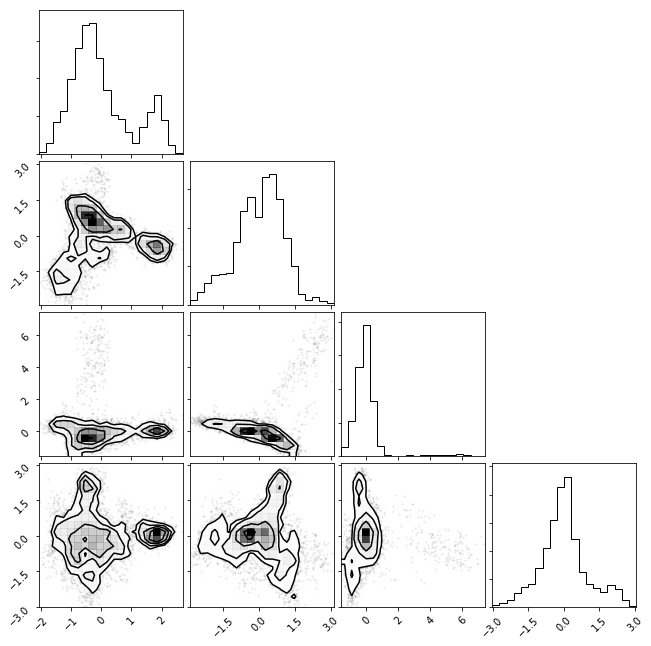

In [7]:
%matplotlib inline
import msmexplorer as msme
import numpy as np
txx = np.concatenate(tica_trajs)
_ = msme.plot_histogram(txx)

In [8]:
from msmbuilder.cluster import MiniBatchKMeans
clusterer = MiniBatchKMeans(n_clusters=100, random_state=42)
clustered_trajs = tica_trajs.fit_transform_with(
    clusterer, 'kmeans/', fmt='dir-npy'
)

print(tica_trajs[0].shape)
print(clustered_trajs[0].shape)

(110, 4)
(110,)


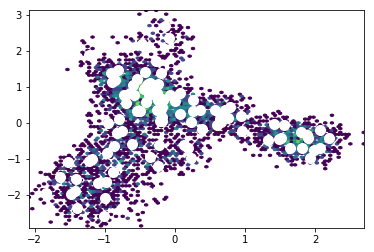

In [9]:
from matplotlib import pyplot as plt
plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap='viridis')
plt.scatter(clusterer.cluster_centers_[:,0],
            clusterer.cluster_centers_[:,1], 
            s=100, c='w')

In [23]:
from msmbuilder.msm import MarkovStateModel
from msmbuilder.utils import dump
msm = MarkovStateModel(lag_time=2, n_timescales=10)
msm.fit(clustered_trajs)

MSM contains 1 strongly connected component above weight=0.50. Component 0 selected, with population 100.000000%


MarkovStateModel(ergodic_cutoff='on', lag_time=2, n_timescales=10,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=True)

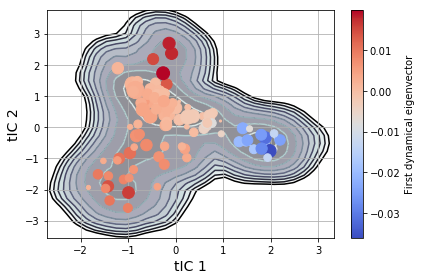

In [11]:
assignments = clusterer.partial_transform(txx)
assignments = msm.partial_transform(assignments)
msme.plot_free_energy(txx, obs=(0, 1), n_samples=10000,
                      pi=msm.populations_[assignments],
                      xlabel='tIC 1', ylabel='tIC 2')
plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=1e4 * msm.populations_,       # size by population
            c=msm.left_eigenvectors_[:, 1], # color by eigenvector
            cmap="coolwarm",
            zorder=3) 
plt.colorbar(label='First dynamical eigenvector')
plt.tight_layout()

In [12]:
msm.timescales_

array([ 130.3519812 ,  112.34712879,   87.92560809,   51.26045696,
         34.93347732,   31.5387223 ,   22.63065025,   15.62280573,
         14.55405973,   12.42066419,   10.67850887,   10.14090488,
          8.49736054,    7.02985936,    6.70539571,    6.10685831,
          5.58580619,    5.43632765,    4.81750298,    4.48631786])

/home/scottzhuang/anaconda3/envs/deepchem/lib/python3.5/site-packages/msmbuilder/msm/msm.py:567: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigma2)


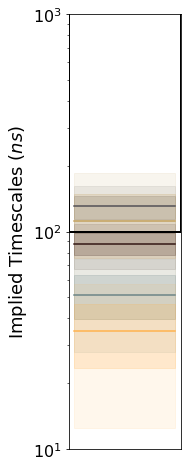

In [13]:
msme.plot_timescales(msm, n_timescales=5,
                     ylabel='Implied Timescales ($ns$)')

In [14]:
from msmbuilder.lumping import PCCAPlus
pcca = PCCAPlus.from_msm(msm, n_macrostates=4)
macro_trajs = pcca.transform(clustered_trajs)

Optimization terminated successfully.
         Current function value: -3.875809
         Iterations: 15
         Function evaluations: 125


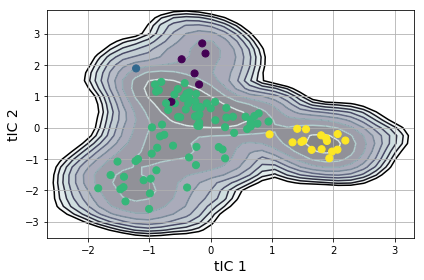

In [15]:
msme.plot_free_energy(txx, obs=(0, 1), n_samples=10000,
                      pi=msm.populations_[assignments],
                      xlabel='tIC 1', ylabel='tIC 2')
plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=50,
            c=pcca.microstate_mapping_,
            zorder=3
           )
plt.tight_layout()